In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Reading and transforming the file
cities = pd.read_csv('GlobalLandTemperaturesByCity.csv')
rio = cities.loc[cities['City'] == 'Rio De Janeiro', ['dt','AverageTemperature']]
rio.columns = ['Date','Temp']
rio['Date'] = pd.to_datetime(rio['Date'])
rio.reset_index(drop=True, inplace=True)
rio.set_index('Date', inplace=True)

#I'm going to consider the temperature just from 1900 until the end of 2012
rio = rio.loc['1900':'2013-01-01']
rio = rio.asfreq('M', method='bfill')
rio.head()

,Temp
Date,
1900-01-31,25.780
1900-02-28,26.160
1900-03-31,23.868
1900-04-30,23.467
1900-05-31,22.667


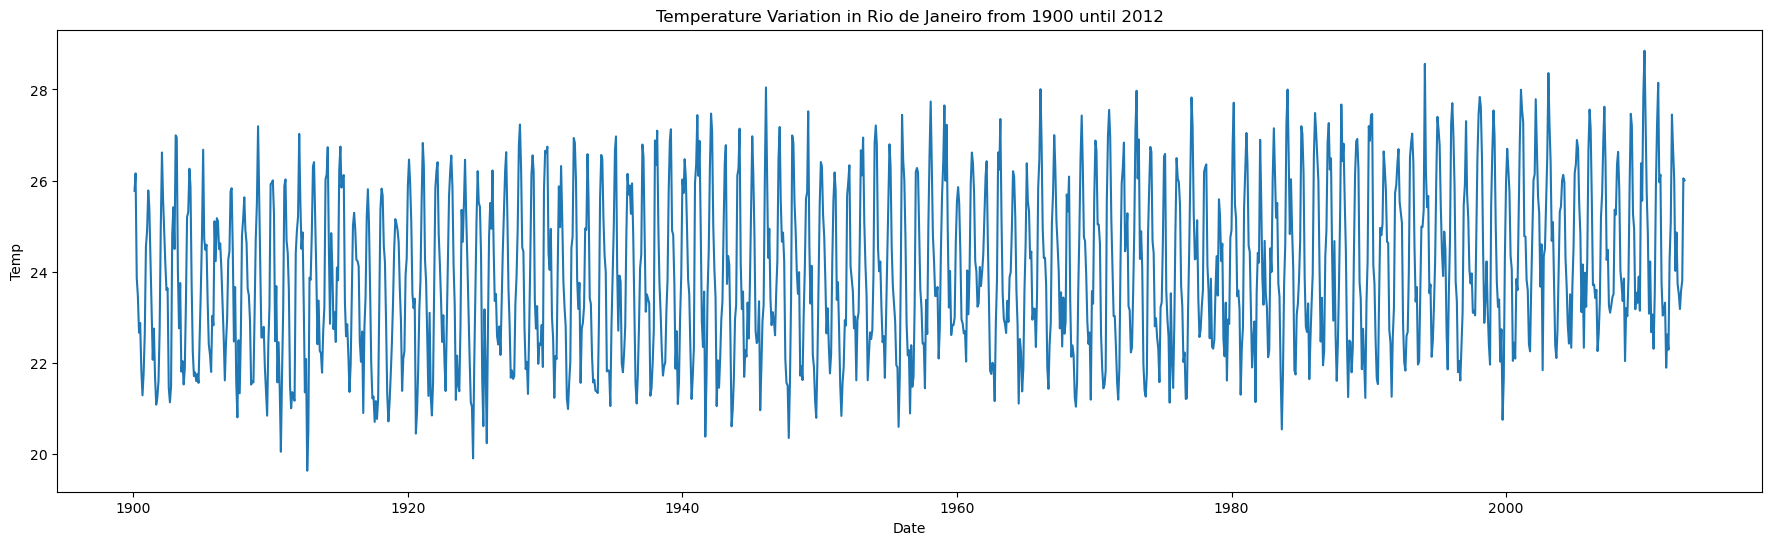

In [4]:
plt.figure(figsize=(22,6))
sns.lineplot(x=rio.index, y=rio['Temp'])
plt.title('Temperature Variation in Rio de Janeiro from 1900 until 2012')
plt.show()

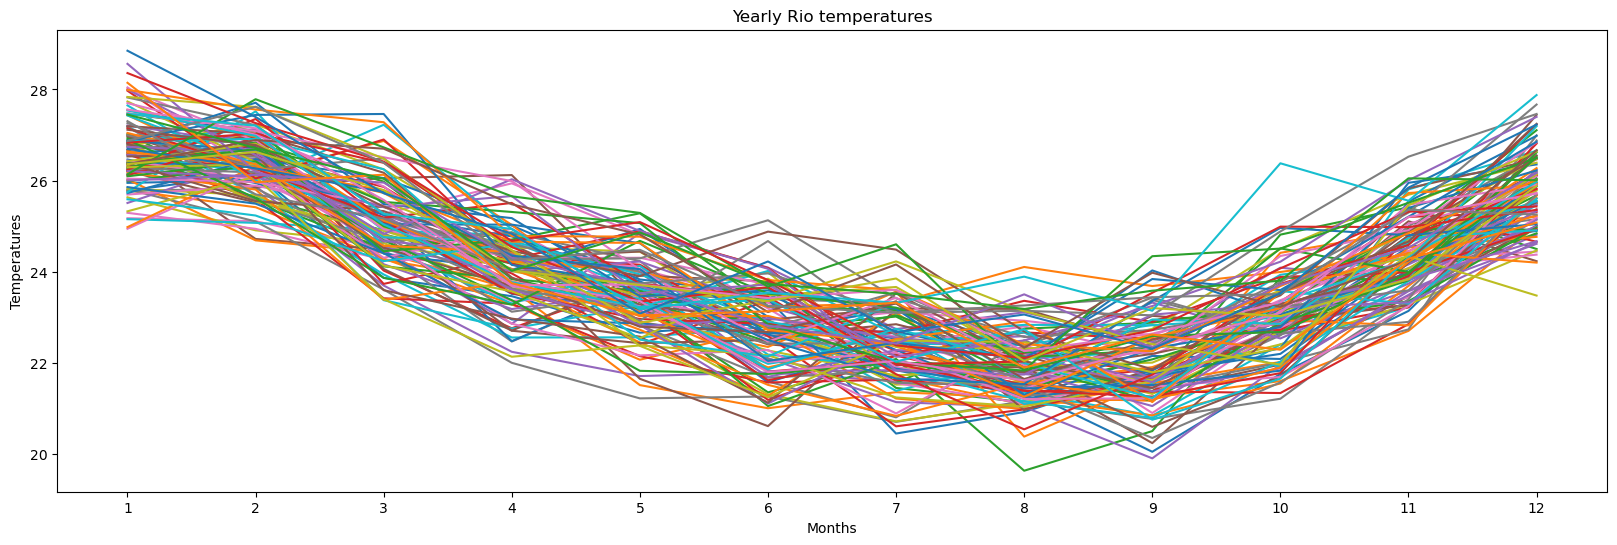

In [5]:
# i'm going to create a pivot table to plot the monthly temperatures through the years
rio['month'] = rio.index.month
rio['year'] = rio.index.year
pivot = pd.pivot_table(rio, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Yearly Rio temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

The series clearly has some seasonality, the higher temperatures are around November and February and the lower are between July and September. Just to make the things clear, I'll merge these lines into just one line, averaging the monthly levels:

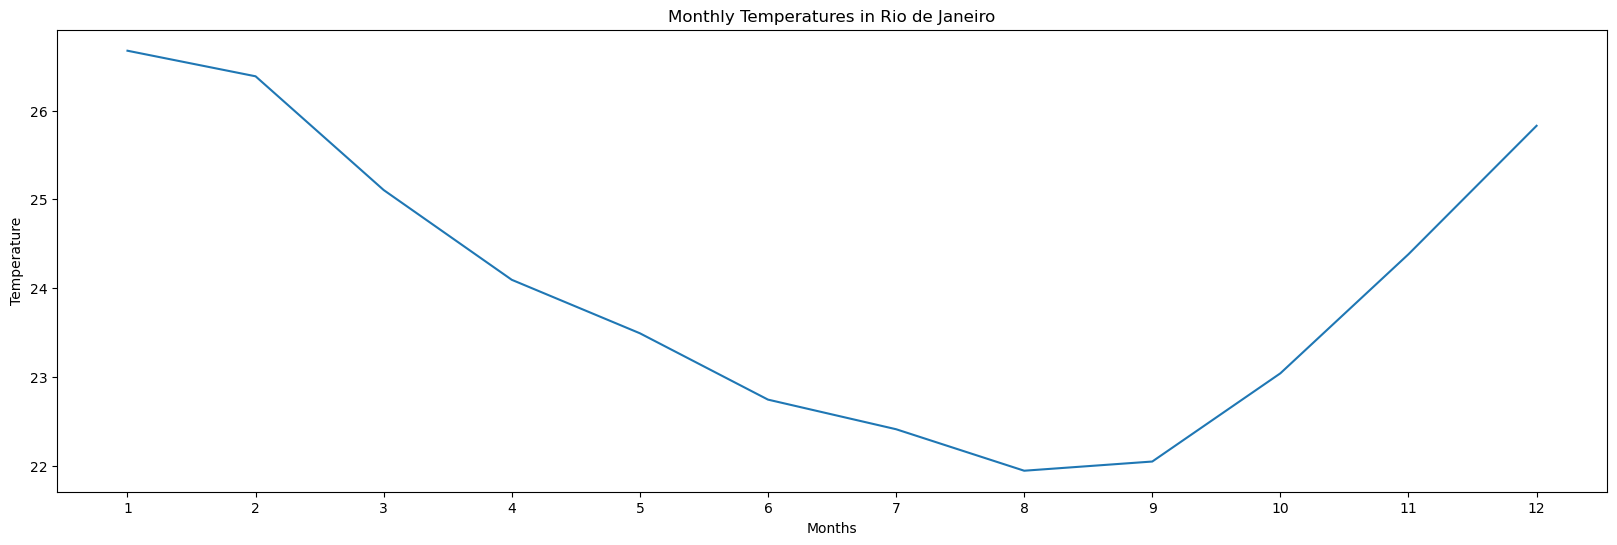

In [6]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Temperatures in Rio de Janeiro')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

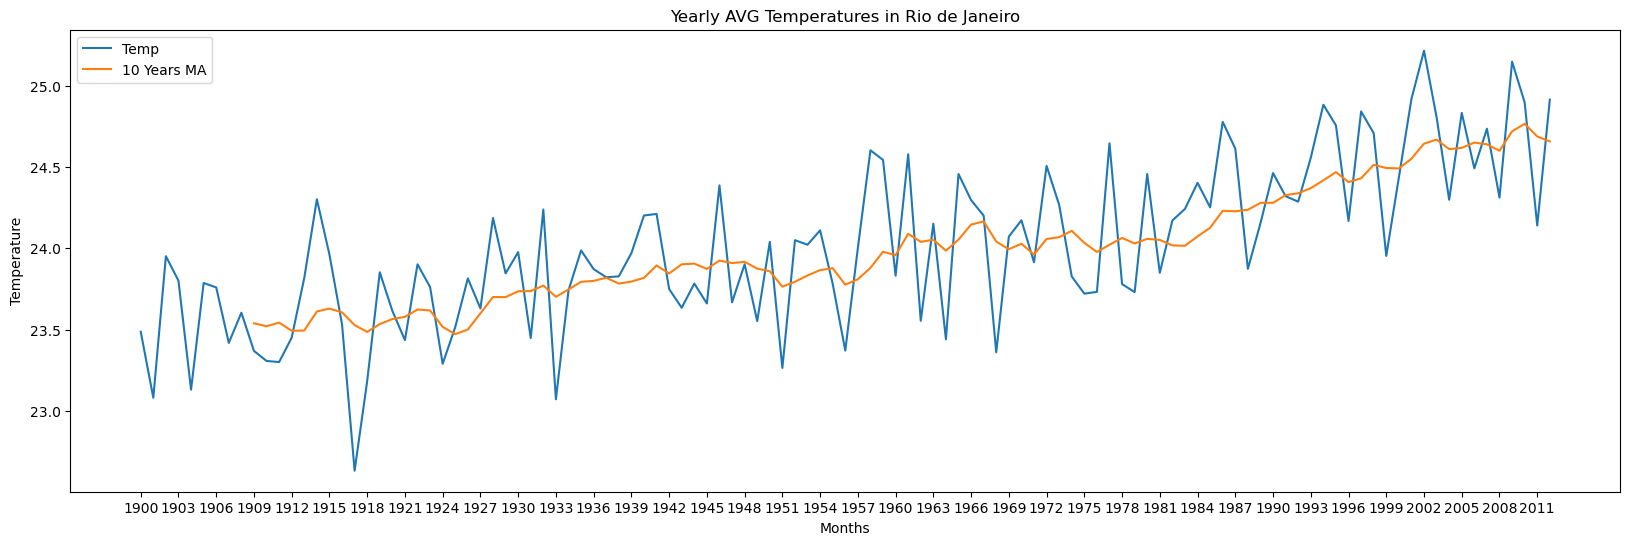

In [7]:
year_avg = pd.pivot_table(rio, values='Temp', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG Temperatures in Rio de Janeiro')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1900,2012,3)])
plt.show()

We can confirm that there is a constant increasing trend and that the average temperature increased from 23.5º to 24.5º, that's 4.25% in over100 years.

Before we go on, i'm going to split the data in training, validation and test set. After training the model, I will use the last 5 years to do the data validation and test, being 48 months to do a month by month validation (walk forward) and 12 months to make an extrapolation for the future and compare to the test set:

In [8]:
train = rio[:-60].copy()
val = rio[-60:-12].copy()
test = rio[-12:].copy()

And before creating the forecasts we will create a baseline forecast in the validation set, in our simulation we will try to have a smaller error compared to this one.

it will consider the previous month as a base forecast to the next month:

In [9]:
# Excluding the first line, as it has NaN values
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-02-29    26.362
2008-03-31    26.631
2008-04-30    25.793
2008-05-31    24.031
2008-06-30    23.713
Freq: M, Name: Temp, dtype: float64

Also I'm going to create a function to use the RMSE as a base to calculate the error, but you are free to use another parameter:

In [10]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 1.3282 celsius degrees


As we can see, the series has a small uptrend and it appears that there is some seasonality with higher temperatures at the begining and end of the year and lower temperatures around the middle of the year.

To create a time series forecast, the series must be stationary (constant mean, variance and autocorrelation).

One way to check if the series is stationary is using the adfuller function, if the P-Value is lower than 5% (usual number used for this kind of study) the series is stationary and you can start creating your model.

If the series isn't stationary you can do some data transformation like using natural logarithm, deflation, differencing, etc.

Below is the function that I used to check the stationarity, it plots:

1. The series itself;
2. The autocorrelation function (ACF):
    It shows the correlation between the current temperatures versus the lagged versions of itself.
3. The partial autocorrelation (PACF):
    It shows the correlation between the current temperatures versus the lagged version excluding the effects of earlier lags, for example, it show the     effective influence of the lag 3 in the current temperatures excluding the effects of the lags 1 and 2

In [11]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Rio de Janeiro Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -3.7599
p-value                           0.0033
Lags Used                        23.0000
Number of Observations Used    1272.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


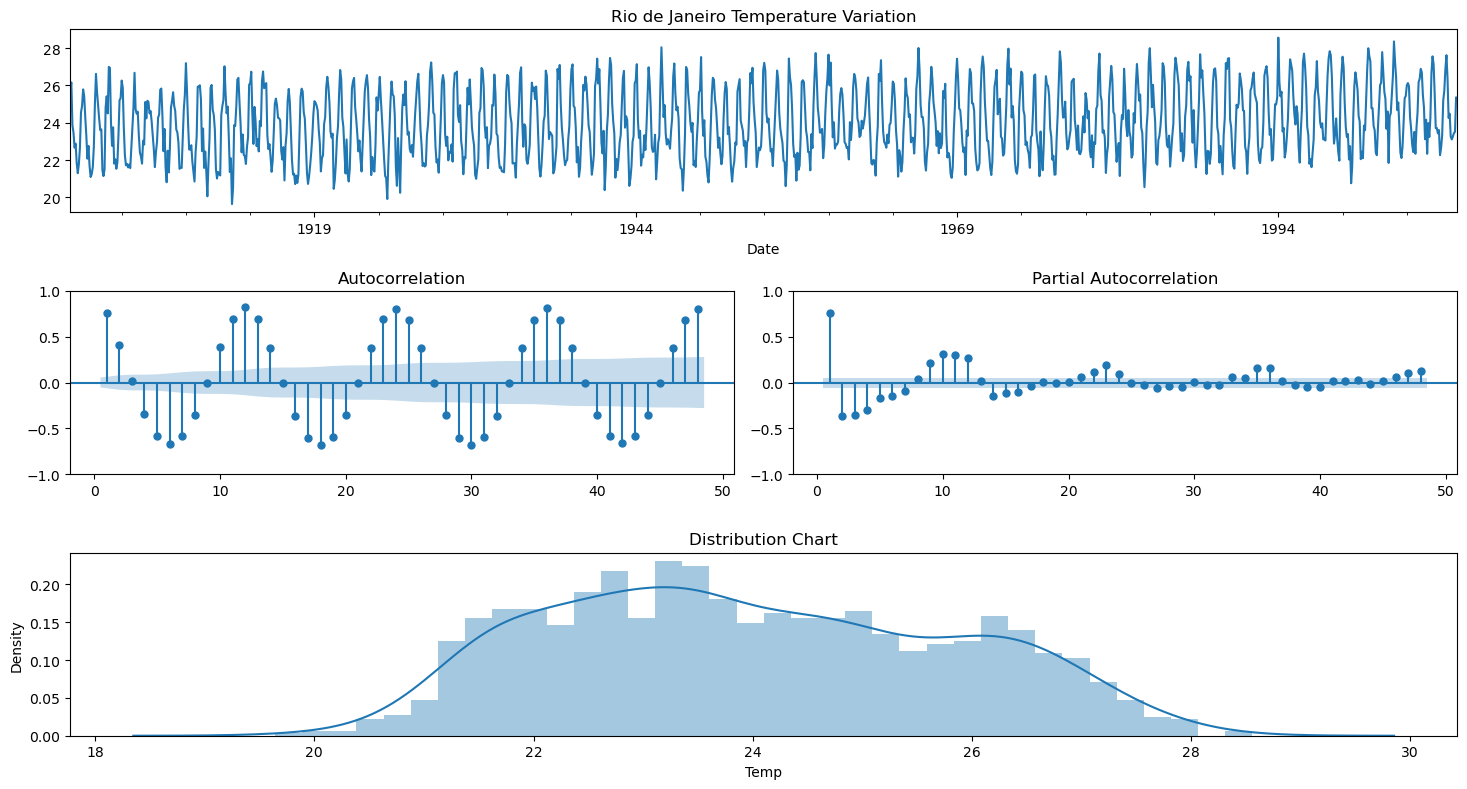

In [12]:
# The first approach is to check the series without any transformation
check_stationarity(train['Temp'])

The series has an interesting behavior, there is a sequential significative negative autocorrelation starting at lag 6 and repeating each 12 months, it's because of the difference in the seasons, if today is winter with cold temperatures in 6 months we will have higher temperatures in the summer, that's why the negative autocorrelation occurs. These temperatures usually walk in opposite directions.

Also, from lag 12 and sequentially from every 12 lags there is a significant positive autocorrelation. The PACF shows a positive spike in the first lag and a drop to negative PACF in the following lags.

This behavior between the ACF and PACF plots suggests an AR(1) model and also a first seasonal difference ( Yt−Yt−12
 ). I'll plot the stationarity function again with the first seasonal difference to see if we will need some SAR(P) or SMA(Q) parameter:

Results of Dickey-Fuller Test:
Test Statistic                  -13.4631
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1260.0000
Critical Value (1%)              -3.4356
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


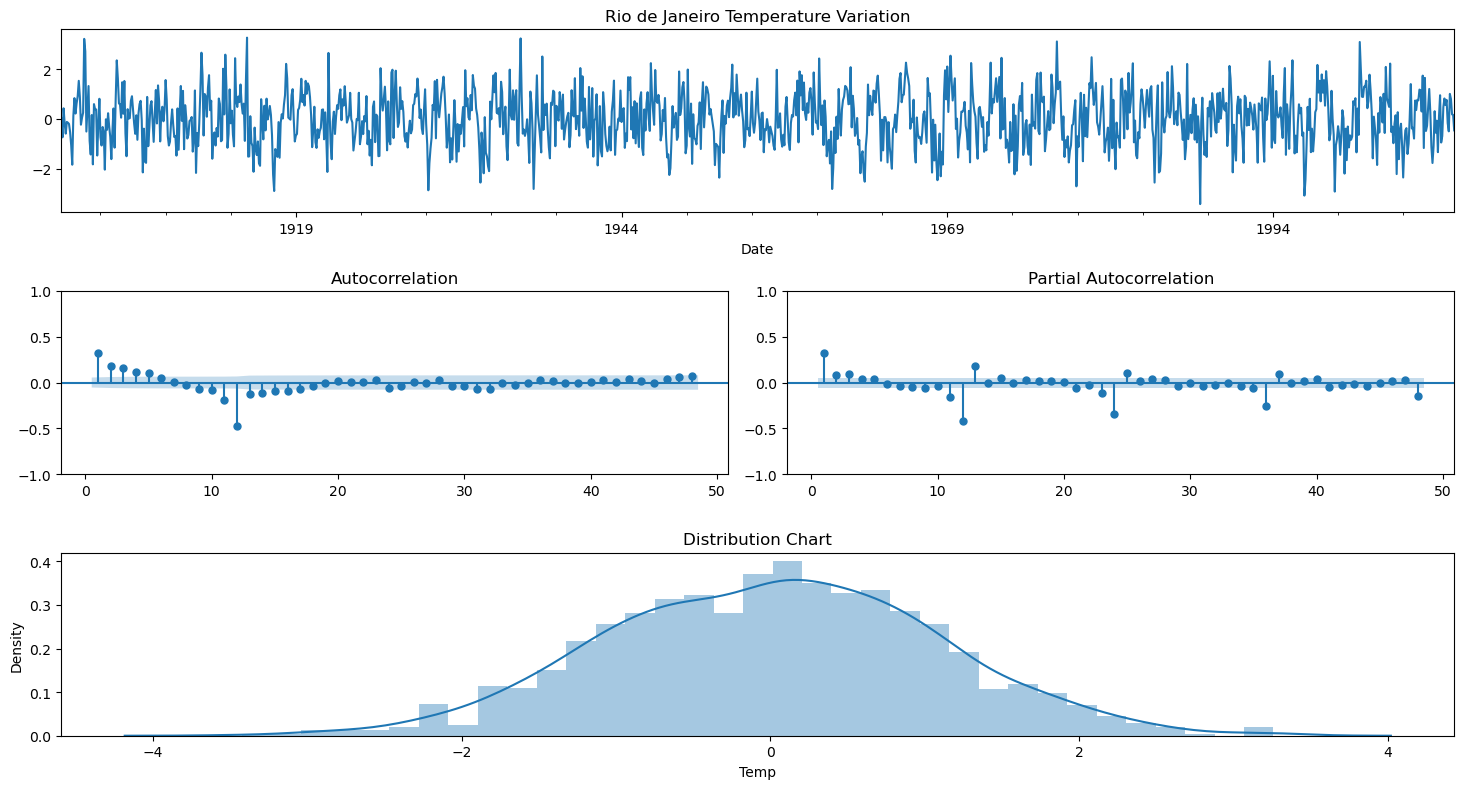

In [13]:
check_stationarity(train['Temp'].diff(12).dropna())


As the plots above showed, the first ACF lags have a gradual decay, while the PACF drops under the confidence interval after the third lag, this is an AR signature with a parameter of 3, so this is an AR(3) model.

As we used a first seasonal difference, the ACF and PACF showed a significative drop in the 12th lag, it means an SMA signature with a parameter of 1 lag, resuming this is an SAR(1) with a first difference.

Initially i'm going to work with the following (p,d,q) orders: (3, 0, 0), and with the following seasonal (P, D, Q, S) orders (0,1,1,12) and as the series has a clear uptrend i'm going to use it in the model ('c').

To start forecasting the validation set, I'm going to create a function to use one-step-forecast in the whole validation set and measure the error:

In [14]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [15]:
# Let's test it in the validation set
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))

In [16]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was 0.7874 celsius degrees
It's a decrease of -40.72% in the RMSE


In [17]:
# Creating the error column
val['Error'] = val['Temp'] - val['Pred']

It's always important to check the residuals, I'm going to create a function to plot some important charts to help us visualize the residuals.

I'm going to plot the following charts:

1. Current and Predicted values through the time.
2. Residuals vs Predicted values in an scatterplot.
3. QQ Plot showing the distribution of errors and its ideal distribution
4. Autocorrelation plot of the Residuals to see if there is some correlation left.

In [18]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [19]:
# We need to remove some columns to plot the charts
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2008-01-31,26.362,26.921159,-0.559159
2008-02-29,26.631,26.707722,-0.076722
2008-03-31,25.793,25.489384,0.303616
2008-04-30,24.031,24.593381,-0.562381
2008-05-31,23.713,23.856267,-0.143267


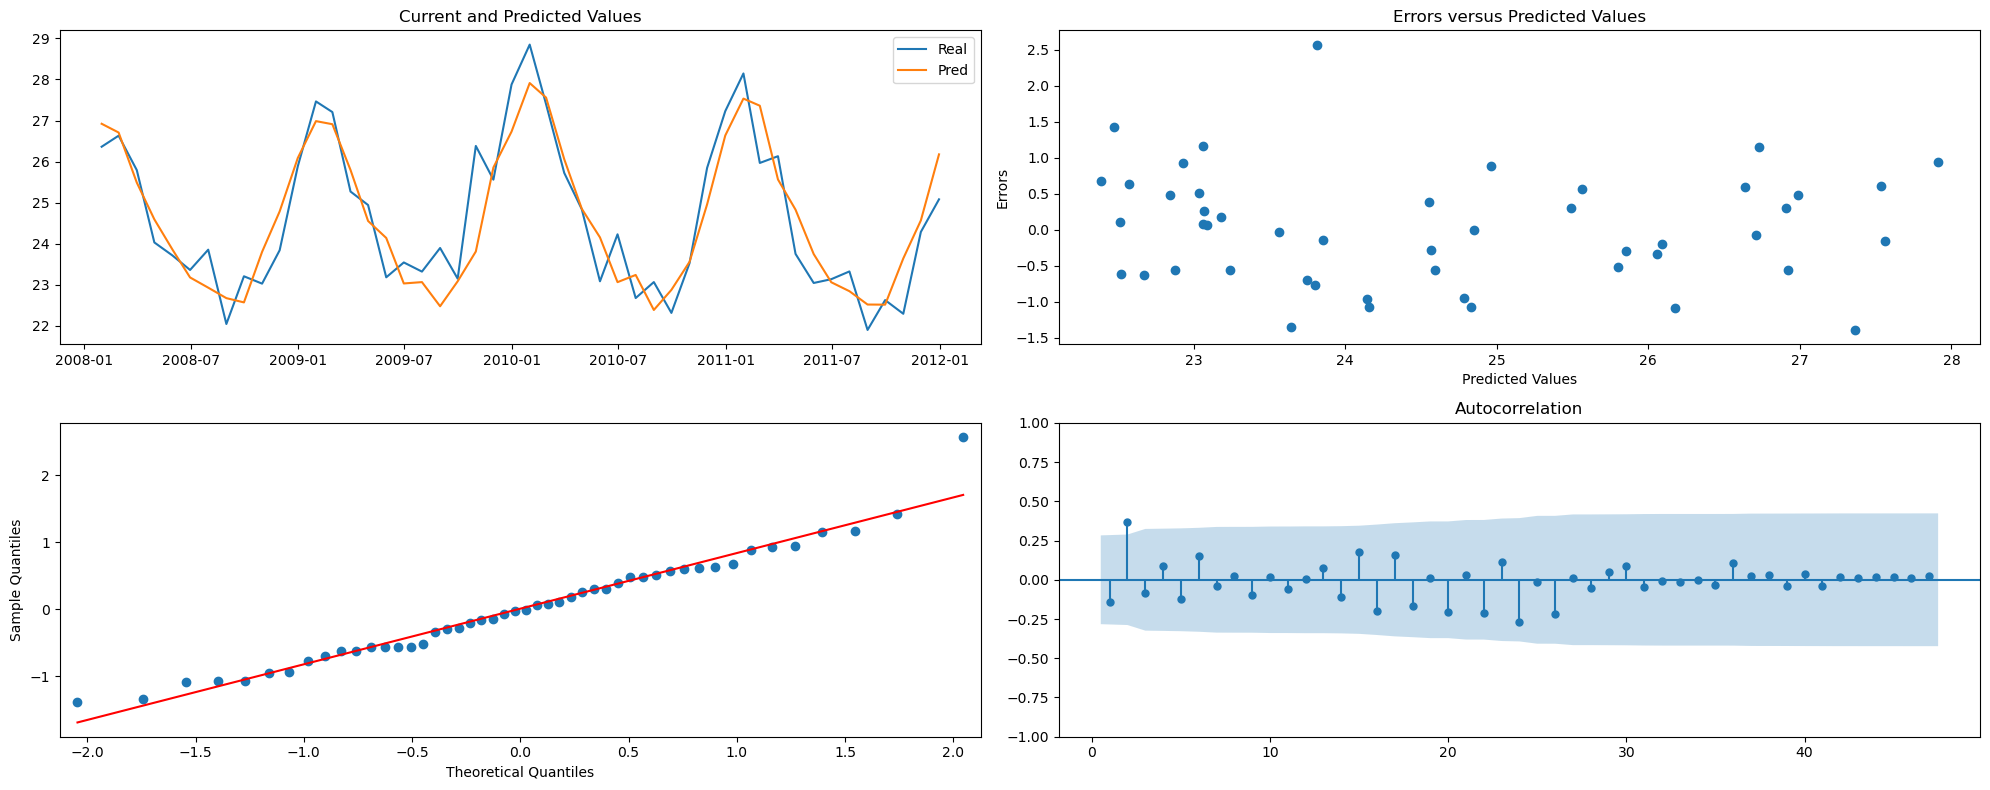

In [20]:
plot_error(val)


Analyzing the plots above we can see that the predictions fit very well on the current values.

The Error vs Predicted values has a linear distribution (the errors are between -1.5 and +1.5 while the temperature increases).

The QQ Plot shows a normal pattern with some little outliers and,

The autocorrelation plot shows a positive spike over the confidence interval just above the second lag, but I believe that there is no need for more changes.

Finally it's time to extrapolate the prediction in the test set for the last 12 months

In [21]:
#Creating the new concatenating the training and validation set:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1900-01-31    25.780
1900-02-28    26.160
1900-03-31    23.868
1900-04-30    23.467
1900-05-31    22.667
Freq: M, Name: Temp, dtype: float64

In [22]:
# Using the same parameters of the fitted model
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

Now I'm going to create a new column on the test set with the predicted values and I will compare them against the real values

In [23]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+13))

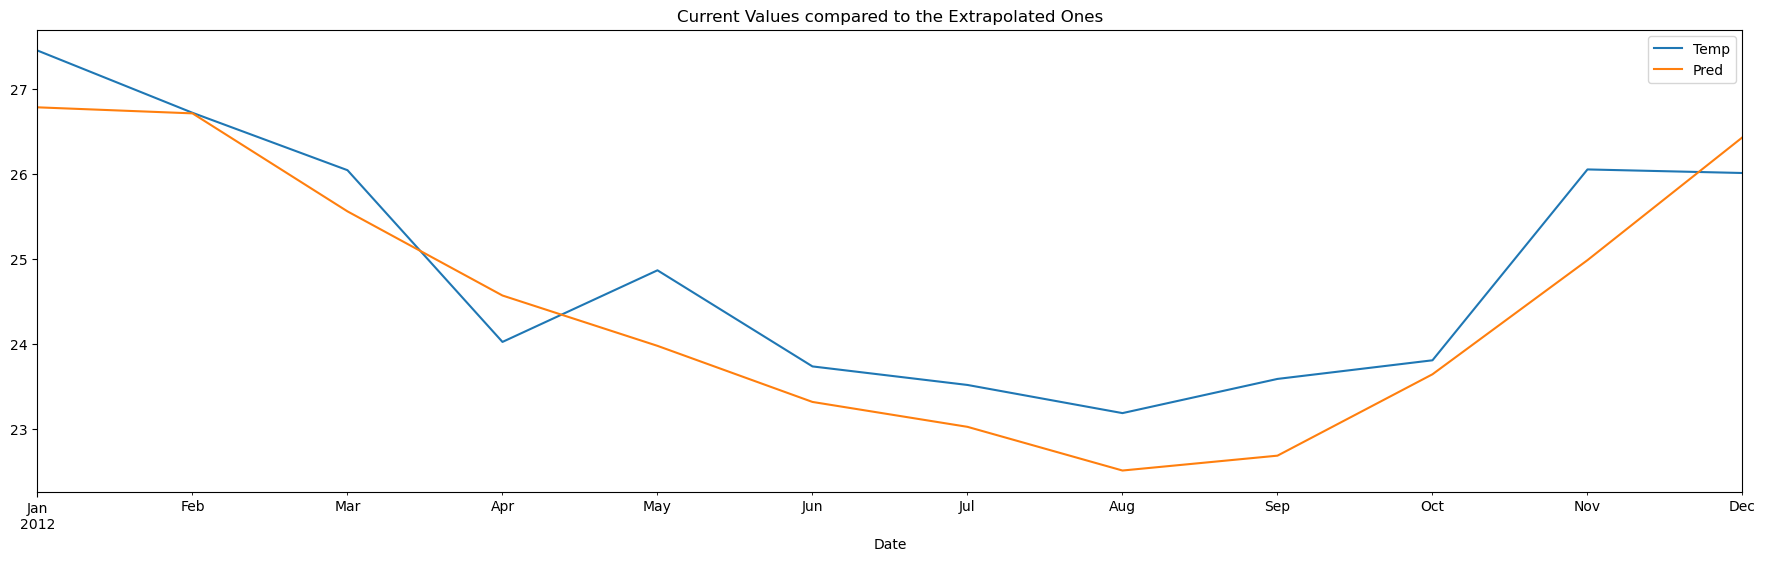

In [24]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

It seems that the SARIMA parameters were well fitted, the predicted values are following the real values and also the seasonal pattern.

Finally I'll evaluate the model with the RMSE in the test set (baseline against the extrapolation):

In [25]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} celsius degrees')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} celsius degrees')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test baseline was 1.02 celsius degrees
The baseline RMSE for the test extrapolation was 0.63 celsius degrees
That is an improvement of 37.96%
